### CDS NYU
### DS-GA 3001 | Reinforcement Learning
### Lab 06
### March 8, 2023


# Implement RL algorithms with Keras-RL or Stable-Baseline

<br>

---

## Professor


Jeremy Curuksu, PhD -- jeremy.cur@nyu.edu

## Section Leader


Anudeep Tubati -- at5373@nyu.edu


## Goal of Today's Lab 

In this Lab, we will implement RL algorithms by building on existing RL algorithm libraries, so we don't have to implement RL agents from scratch as we did in the past few weeks. By doing so, we get less control on the details of the implementation, but it is much faster to implement (**we will cover 4 case studies today:** `CartPole`, `SpaceInvaders`, `CarRacing`, and `StockTrading`), and components available in public libraries tend to be high quality and efficient. 

Let us start with the DQN algorithm. We can use external open-source Python packages which implement each of the key DQN methods (e,g., experience replay method, action-selection method, etc). These methods are developed, maintained, and optimized for robustness to different scenarios, and for overall performance.

Using these packages instead of implementing each DQN component from scratch is generally faster, leads to a more reliable/efficient program, yet still gives you a lot of control on the details of the implementation and hyperparameters.

We will focus on DQN in the first part of the lab, but these packages also offer methods for most commonly used RL algorithms such as A3C, PPO, etc, so we will start looking at these too.

## Resources

* https://gymnasium.farama.org/


# 1. Implement DQN with Keras-RL methods

---------


# 1.1 Solve *Cart Pole*  with DQN from Keras-rl

Most of this case study will be the same as in previous lab, but we build some of the key components of the DQN agent using components available in the Keral-RL library

## Imports

In [1]:
import time 
import gym
from pyglet.window import key 
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import Activation 
from tensorflow.keras.layers import Flatten  
from tensorflow.keras.optimizers import Adam  # Adam optimizer

# Import DQN methods from the keras-rl2 library (keras-rl is tagged "rl" in Python)
from rl.agents.dqn import DQNAgent 

## Set up the `CartPole` Gym environment

In [2]:
# https://stackoverflow.com/questions/56904270/difference-between-openai-gym-environments-cartpole-v0-and-cartpole-v1
env_name = ENV_NAME = 'CartPole-v0'
env = gym.make(env_name)  

# Same as last week:
num_actions = env.action_space.n
num_observations = env.observation_space.shape[0]  
print(f"There are {num_actions} possible actions and {num_observations} observations")


There are 2 possible actions and 4 observations


## Execute random actions just to get familiar with the environment

In [2]:
# Load the CartPole Gym environment with graphical rendering to vizualize the environment
env = gym.make("CartPole-v0", render_mode="human")  # [Jeremy] was v1 last week  

# Set to initial state
env.reset()  

# Loop over 200 steps
for _ in range(200):
    env.render()                                                 # Render on the screen
    action = env.action_space.sample()                           # Choose a random action
    new_state, reward, done, truncated, info = env.step(action)  # Carry out the action
    
    if done:
         env.reset()
            
env.close()


NameError: name 'gym' is not defined

## Implement an Artificial Neural Network
To build our network, we first need to find out how many actions and observation our environment has.
We can either get those information from the source code (https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) or via the following commands:

Similar to in the previous lab, we build a simple ANN with 2 hidden layers and 16 and 32 neurons each followed by relu activation. The output layer has 2 nodes, one for each action

In [3]:
model = Sequential()
# https://keras.io/api/layers/reshaping_layers/flatten/
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(num_actions))
model.add(Activation('linear'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
 activation_2 (Activation)   (None, 2)                 0

## Implement the DQN framework with Keras-RL

The DQN agent `DQNagent` from Keras-RL takes the following parameters:

1. `model` = The ANN


2. `nb_actions` = The number of actions (2 in this case)


3. `memory` = The action replay memory. Ny far the most common choice is `SequentialMemory()` 


4. `nb_steps_warmup` = Number of iterations used to fill the memory prior starting to update the ANN parameters


5. `target_model_update` = How often (in number of steps) to update the target model


6. `policy` = You can choose between `LinearAnnealedPolicy()`, `SoftmaxPolicy()`, `EpsGreedyQPolicy()`, `GreedyQPolicy()`, `GreedyQPolicy()`, `MaxBoltzmannQPolicy()` and `BoltzmannGumbelQPolicy()`. We will use the `LinearAnnealedPolicy` policy, but feel free to try them out and inspect which works best here


There are some more parameters you can pass to the DQN Agent, feel free to explore them on your own.

let's initialize a circular buffer with a limit of 20000 and window length of 1 (window length describes the number of steps stored to define a state)


In [4]:
from rl.memory import SequentialMemory  # Sequential Memory for storing observations (optimized circular buffer)

memory = SequentialMemory(limit=20000, window_length=1)


Then we define the Action Selection Policy: <br />
We use *LinearAnnealedPolicy* in order to perform the epsilon greedy strategy with decaying epsilon. <br />
*LinearAnnealedPolicy* accepts an action selection policy, its maximal and minimal values and a step number in order to create a dynamical policy. <br/>
The smallest value epsilon can reach during training is 0.1.<br />
For testing/evaluation of the trained agent, let's set epsilon to 0.05


In [5]:
# LinearAnnealedPolicy allows to decay the epsilon for the epsilon greedy strategy
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps',
                              value_max=1.,
                              value_min=.1,
                              value_test=.05,
                              nb_steps=20000) 


Now we create the DQN Agent based on the defined model (**model**), the possible actions (**num_actions**) (left and right in this case), the circular buffer (**memory**), the warmup phase (**10**), how often the target model gets updated (**100**) and the policy (**policy**)


In [6]:
dqn = DQNAgent(model = model, nb_actions = num_actions, memory = memory, nb_steps_warmup = 10,
               target_model_update = 100, policy = policy)



We can now compile the DQN with the Adam optimizer and a learning rate of 0.001.<br />
We log the Mean Absolute Error

In [7]:
# Use learning_rate instead of lr if you get warning
dqn.compile(Adam(lr=1e-3), metrics=['mae']) 

/Users/jcur/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-01-14 17:55:13.577217: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Let's run the training for 20000 steps. You can change visualize=True if you want to watch your model learning.
Keep in mind that this increases the running time.


## Train the DQN agent

In [8]:
dqn.fit(env, nb_steps=20000, visualize=False, verbose=2)

Training for 20000 steps ...


/Users/jcur/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/Users/jcur/opt/anaconda3/envs/py39/lib/python3.9/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


    39/20000: episode: 1, duration: 0.205s, episode steps:  39, steps per second: 190, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.590 [0.000, 1.000],  loss: 0.426251, mae: 0.509380, mean_q: 0.149565, mean_eps: 0.998898
    56/20000: episode: 2, duration: 0.025s, episode steps:  17, steps per second: 670, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 0.253313, mae: 0.509869, mean_q: 0.440866, mean_eps: 0.997885
    67/20000: episode: 3, duration: 0.017s, episode steps:  11, steps per second: 632, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 0.161789, mae: 0.516685, mean_q: 0.686445, mean_eps: 0.997255
    85/20000: episode: 4, duration: 0.027s, episode steps:  18, steps per second: 675, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 0.112104, mae: 0.553165, mean_q: 0.834521, mean_ep

   781/20000: episode: 34, duration: 0.052s, episode steps:  38, steps per second: 735, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 0.978211, mae: 4.231070, mean_q: 7.988684, mean_eps: 0.965732
   809/20000: episode: 35, duration: 0.042s, episode steps:  28, steps per second: 671, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.393 [0.000, 1.000],  loss: 0.891152, mae: 4.312921, mean_q: 8.073896, mean_eps: 0.964248
   827/20000: episode: 36, duration: 0.027s, episode steps:  18, steps per second: 678, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 0.986165, mae: 4.639972, mean_q: 8.888438, mean_eps: 0.963212
   840/20000: episode: 37, duration: 0.019s, episode steps:  13, steps per second: 673, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 1.137414, mae: 4.610753, mean_q: 8.654111, mea

  1582/20000: episode: 69, duration: 0.021s, episode steps:  15, steps per second: 704, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 1.240901, mae: 7.037356, mean_q: 13.857292, mean_eps: 0.929170
  1594/20000: episode: 70, duration: 0.017s, episode steps:  12, steps per second: 692, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 0.765481, mae: 6.980628, mean_q: 13.928174, mean_eps: 0.928562
  1614/20000: episode: 71, duration: 0.028s, episode steps:  20, steps per second: 706, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 1.275429, mae: 7.097784, mean_q: 13.973377, mean_eps: 0.927843
  1641/20000: episode: 72, duration: 0.037s, episode steps:  27, steps per second: 731, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 1.308116, mae: 7.339356, mean_q: 14.589383,

  2366/20000: episode: 102, duration: 0.063s, episode steps:  45, steps per second: 717, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 1.988946, mae: 10.414171, mean_q: 20.844454, mean_eps: 0.894565
  2381/20000: episode: 103, duration: 0.021s, episode steps:  15, steps per second: 703, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 1.438334, mae: 10.589921, mean_q: 21.367934, mean_eps: 0.893215
  2415/20000: episode: 104, duration: 0.047s, episode steps:  34, steps per second: 729, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 2.633751, mae: 10.752328, mean_q: 21.427767, mean_eps: 0.892112
  2427/20000: episode: 105, duration: 0.017s, episode steps:  12, steps per second: 693, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 1.968415, mae: 10.880632, mean_q: 21

  3308/20000: episode: 139, duration: 0.028s, episode steps:  19, steps per second: 688, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.632 [0.000, 1.000],  loss: 2.673317, mae: 14.561040, mean_q: 29.599327, mean_eps: 0.851590
  3335/20000: episode: 140, duration: 0.038s, episode steps:  27, steps per second: 720, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 2.678595, mae: 14.717828, mean_q: 29.910179, mean_eps: 0.850555
  3348/20000: episode: 141, duration: 0.019s, episode steps:  13, steps per second: 695, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 3.726033, mae: 15.146224, mean_q: 30.552428, mean_eps: 0.849655
  3360/20000: episode: 142, duration: 0.017s, episode steps:  12, steps per second: 696, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 1.921117, mae: 14.464986, mean_q: 29

  4489/20000: episode: 174, duration: 0.030s, episode steps:  21, steps per second: 709, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.619 [0.000, 1.000],  loss: 2.464521, mae: 19.338966, mean_q: 39.959061, mean_eps: 0.798490
  4550/20000: episode: 175, duration: 0.086s, episode steps:  61, steps per second: 712, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 2.269735, mae: 19.883640, mean_q: 40.911586, mean_eps: 0.796645
  4623/20000: episode: 176, duration: 0.102s, episode steps:  73, steps per second: 717, episode reward: 73.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 3.308966, mae: 19.992589, mean_q: 40.883209, mean_eps: 0.793630
  4650/20000: episode: 177, duration: 0.038s, episode steps:  27, steps per second: 705, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 3.148566, mae: 20.806569, mean_q: 42

  6039/20000: episode: 209, duration: 0.062s, episode steps:  44, steps per second: 711, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 5.903746, mae: 28.895439, mean_q: 59.592115, mean_eps: 0.729258
  6150/20000: episode: 210, duration: 0.155s, episode steps: 111, steps per second: 718, episode reward: 111.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 7.197909, mae: 29.242330, mean_q: 60.256227, mean_eps: 0.725770
  6171/20000: episode: 211, duration: 0.030s, episode steps:  21, steps per second: 696, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 7.779584, mae: 29.913053, mean_q: 61.652086, mean_eps: 0.722800
  6216/20000: episode: 212, duration: 0.063s, episode steps:  45, steps per second: 713, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 8.664182, mae: 29.815086, mean_q: 6

  8102/20000: episode: 243, duration: 0.143s, episode steps: 104, steps per second: 727, episode reward: 104.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 15.288963, mae: 42.587930, mean_q: 87.663093, mean_eps: 0.637772
  8131/20000: episode: 244, duration: 0.040s, episode steps:  29, steps per second: 728, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 15.429323, mae: 43.905103, mean_q: 90.238639, mean_eps: 0.634780
  8204/20000: episode: 245, duration: 0.098s, episode steps:  73, steps per second: 744, episode reward: 73.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 16.996475, mae: 43.869675, mean_q: 90.381793, mean_eps: 0.632485
  8275/20000: episode: 246, duration: 0.096s, episode steps:  71, steps per second: 739, episode reward: 71.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 16.521215, mae: 44.098762, mean_

 10779/20000: episode: 276, duration: 0.078s, episode steps:  55, steps per second: 709, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 14.867702, mae: 60.434970, mean_q: 124.930960, mean_eps: 0.516205
 10809/20000: episode: 277, duration: 0.044s, episode steps:  30, steps per second: 686, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.433 [0.000, 1.000],  loss: 14.458059, mae: 59.961059, mean_q: 124.161666, mean_eps: 0.514293
 10927/20000: episode: 278, duration: 0.166s, episode steps: 118, steps per second: 712, episode reward: 118.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 29.284376, mae: 61.583908, mean_q: 126.689180, mean_eps: 0.510962
 11074/20000: episode: 279, duration: 0.205s, episode steps: 147, steps per second: 716, episode reward: 147.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 27.551232, mae: 62.683894, m

 15538/20000: episode: 310, duration: 0.238s, episode steps: 171, steps per second: 719, episode reward: 171.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 34.210911, mae: 78.769893, mean_q: 160.807462, mean_eps: 0.304660
 15738/20000: episode: 311, duration: 0.277s, episode steps: 200, steps per second: 722, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 33.985294, mae: 79.831938, mean_q: 162.756166, mean_eps: 0.296312
 15827/20000: episode: 312, duration: 0.125s, episode steps:  89, steps per second: 712, episode reward: 89.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 49.462118, mae: 80.896015, mean_q: 164.588579, mean_eps: 0.289810
 16027/20000: episode: 313, duration: 0.279s, episode steps: 200, steps per second: 717, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 39.943547, mae: 80.215595, 

After just 1-2 minutes of training (for reference, it takes < 1min on a Macbook Air with M2), we achieve some great results already. It was taking at least 15 minutes of training to reach a similar level of performance with the custom DQN implemented from scratch in the previous lab.

The reason for this is that keras-rl has implemented many optimization strategies (e.g., the optimized replay buffer) which lead to a significantly faster convergence than the DQN we implemented by hand.

In [9]:
# After training is done, we can save the final weights.
dqn.save_weights(f'dqn_{env_name}_weights.h5f', overwrite=True)

## Exploit learned Q values in test simulations

The Keras-RL agents also offer methods to perform tests in Gym, with some parameters e.g. to decide whether to render the simulation graphically.

In [15]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)
env.close()

Testing for 5 episodes ...
Episode 1: reward: 173.000, steps: 173
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 168.000, steps: 168
Episode 4: reward: 191.000, steps: 191
Episode 5: reward: 200.000, steps: 200


All in all, we accomplished a better agent (trained more efficiently) with much less code than in the previous lab, thanks to Keras-RL!

---------

# 1.2 Solve *Space Invaders*  with Convolutional DQN from Keras-rl

## Imports

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam

from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

import gym
env = gym.make('SpaceInvaders-v0')


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


## Execute random actions just to get familiar with the environment

In [ ]:
env = gym.make('SpaceInvaders-v0', render_mode='human')

episodes = 10

for episode in range(1, episodes):
    state = env.reset()
    done = False
    score = 0
    
    while not done:
        #env.render()
        state, reward, done, info = env.step(env.action_space.sample())
        score += reward
    print('Episode: {}\nScore: {}'.format(episode, score))
    
env.close()

## Implement a Convolutional Neural Network

In [2]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Conv2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3, height, width, channels)))
    model.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [3]:
height, width, channels = env.observation_space.shape
actions = env.action_space.n

In [4]:
#del model # [Jeremy] why do we need this? TBD

In [5]:
model = build_model(height, width, channels, actions)

## Implement the DQN framework 

In [6]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=2000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg',
                  nb_actions=actions, nb_steps_warmup=1000)
    return dqn

In [7]:
dqn = build_agent(model, actions)

In [8]:
dqn.compile(Adam(lr=0.001))

/Users/jcur/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-01-14 18:05:10.364387: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [10]:
dqn.fit(env, nb_steps = 40000, visualize = False, verbose = 1) # Train for 1000 steps in class, try 40000 at home :)

Training for 1000 steps ...
Interval 1 (0 steps performed)
  999/10000 [=>............................] - ETA: 1:37 - reward: 0.2002done, took 10.839 seconds


In [23]:
#dqn.save_weights('SpaceInvaderTrainedModel/dqn.h5f')

[WARNING] SpaceInvaderTrainedModel/dqn.h5f.index already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


## Exploit learned Q values in test simulations

In [9]:
#dqn.load_weights('SpaceInvaderTrainedModel/dqn.h5f')


Two checkpoint references resolved to different objects (<keras.layers.convolutional.Conv2D object at 0x2826baf70> and <keras.layers.core.flatten.Flatten object at 0x2826d67c0>).


ValueError: Layer weight shape (4, 4, 64, 64) not compatible with provided weight shape (82944, 512)

In [11]:
env = gym.make('SpaceInvaders-v0', render_mode = 'human') # Added because with visualize = True it crashes with message that render-'human' is obsolete

scores = dqn.test(env, nb_episodes = 10, visualize = False)  # Would need play with versioning to use the vizualize parameter (currently fixed with line above)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 285.000, steps: 985


KeyboardInterrupt: 

# 2. Implement DQN with Stable-baselines algorithms

Instead of implementing DQN from scratch (previous lab), or its individual components from external packages as seen in the section above, yet other packages exist which offer a "complete" implementation of the most popular RL algorithms (DQN, A3C, PPO, DDPG, etc).

Many such packages exist. The most popular ones include OpenAI `Stable-baselines`, DeepMind `Acme`, AWS `SageMaker RL`, Meta `AI ReAgent`, Ray `RLlib`, Intel `AI Coach`. 

Today we will focus exclusively on `Stable-baselines` because it was initially designed by OpenAI in tandem with `Gym` environments. In the final labs of the semester will introduce several other frameworks.


These implementations of RL algorithms have been optimized for ease-of-use, robustness to different scenarios, and overall performance. Their drawback is you get less control on details of the implementation and hyperparameters, compared to using packages such as `Keras-RL` which only implement key *components* of RL algorithms.


# 2.1 Play 'Car Racing' with Convolutional PPO from Stable-baselines

## Imports

In [1]:
import gym
from stable_baselines3 import PPO 
from stable_baselines3.common.evaluation import evaluate_policy

## Set up the `CarRacing` Gym environment

In [2]:
env = gym.make('CarRacing-v0')
env.observation_space.sample().shape
env.action_space.sample()
#env.reset()
#env.render()
env.close()

## Execute random actions just to get familiar with the environment

In [8]:
episodes = 5
for episode in range(episodes):
    state = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print("Episode: {} Score: {}".format(episode, score))
    
env.close()

Track generation: 1038..1308 -> 270-tiles track
Episode: 0 Score: -25.65055762081816
Track generation: 1131..1418 -> 287-tiles track
Episode: 1 Score: -33.566433566434014
Track generation: 1216..1524 -> 308-tiles track
Episode: 2 Score: -34.853420195440286
Track generation: 1112..1394 -> 282-tiles track
Episode: 3 Score: -28.825622775801026
Track generation: 1029..1290 -> 261-tiles track
Episode: 4 Score: -23.076923076923272


## Train the `PPO` algorithm from `stable-baselines`

In [3]:
model = # FILL

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [4]:
# Train the model
# TODO

Track generation: 1089..1370 -> 281-tiles track
Track generation: 1038..1302 -> 264-tiles track
Track generation: 1264..1584 -> 320-tiles track
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -53.9    |
| time/              |          |
|    fps             | 341      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
Track generation: 1204..1509 -> 305-tiles track
Track generation: 1326..1662 -> 336-tiles track
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -54.4        |
| time/                   |              |
|    fps                  | 116          |
|    iterations           | 2            |
|    time_elapsed         | 35           |
|    total_timesteps      | 4096         |
| train/                  |      

Track generation: 1136..1424 -> 288-tiles track
Track generation: 1188..1489 -> 301-tiles track
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -45         |
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 10          |
|    time_elapsed         | 267         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.026370635 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.06       |
|    explained_variance   | 0.428       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00697     |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0331     |
|    std                  | 0.928       |
|    value_loss           | 0.294       |
----------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -49.6       |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 18          |
|    time_elapsed         | 501         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.030727487 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.74       |
|    explained_variance   | 0.797       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0371     |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0359     |
|    std                  | 0.838       |
|    value_loss           | 0.134       |
-----------------------------------------
Track generation: 1201..1505 -> 304-tiles track
Track generation: 1136..1424

Track generation: 1062..1332 -> 270-tiles track
Track generation: 1304..1634 -> 330-tiles track
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -55.9      |
| time/                   |            |
|    fps                  | 72         |
|    iterations           | 27         |
|    time_elapsed         | 766        |
|    total_timesteps      | 55296      |
| train/                  |            |
|    approx_kl            | 0.05309065 |
|    clip_fraction        | 0.343      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.47      |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00783   |
|    n_updates            | 260        |
|    policy_gradient_loss | -0.0405    |
|    std                  | 0.767      |
|    value_loss           | 0.0845     |
----------------------------------------
Tr

Track generation: 1188..1489 -> 301-tiles track
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | -42        |
| time/                   |            |
|    fps                  | 71         |
|    iterations           | 35         |
|    time_elapsed         | 999        |
|    total_timesteps      | 71680      |
| train/                  |            |
|    approx_kl            | 0.10699357 |
|    clip_fraction        | 0.506      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.19      |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00123   |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.0394    |
|    std                  | 0.698      |
|    value_loss           | 0.687      |
----------------------------------------
Track generation: 1172..1469 -> 297-tiles track
Tr

## Exploit the trained agent in test simulations

In [5]:
# Evaluate the policy
# TODO

/Users/jcur/opt/anaconda3/envs/py39/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Track generation: 892..1125 -> 233-tiles track
Track generation: 1222..1532 -> 310-tiles track
Track generation: 1001..1263 -> 262-tiles track
Track generation: 1123..1408 -> 285-tiles track
Track generation: 1068..1344 -> 276-tiles track
Track generation: 1034..1296 -> 262-tiles track


(333.3835589855909, 84.6444735352028)

In [16]:
env.close()

**Exercice:** Try increase the performance of this agent by exploring hyperparameters available in stable-baseline for PPO, such as number of training steps, or even by testing another type of agent

# 2.2 Trade a S&P 500 stock index with DQN from Stable-baselines


In [17]:
import gym
from stable_baselines3.common.vec_env import DummyVecEnv 
from stable_baselines3 import A2C 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For this case study please install the following libraries: gym_anytrading, yfinance, pandas_datareader, TA
import gym_anytrading
from gym_anytrading.envs import StocksEnv
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override() # bug fix, for details see https://stackoverflow.com/questions/74862453/why-am-i-getting-a-typeerror-string-indices-must-be-integer-message-when-tryi
from ta import add_all_ta_features # Method from TA (Technical Analysis) library to engineer financial indicators


## Set up the S&P 500 stock index trading environment

Read some daily time series stock data

In [18]:
df = pdr.get_data_yahoo('SPY', start='2021-01-01', end='2023-01-01')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,375.309998,375.450012,364.820007,368.790009,358.128723,110210800
2021-01-05,368.100006,372.500000,368.049988,371.329987,360.595276,66426200
2021-01-06,369.709991,376.980011,369.119995,373.549988,362.751129,107997700
2021-01-07,376.100006,379.899994,375.910004,379.100006,368.140625,68766800
2021-01-08,380.589996,381.489990,377.100006,381.260010,370.238251,71677200


Set up the Gym trading environment

In [19]:
env = gym.make('stocks-v0', df=df, frame_bound=(5, 400), window_size=5)

In [20]:
env.action_space

Discrete(2)

## Execute random actions just to get familiar with the environment

{'total_reward': 78.54989624023438, 'total_profit': 0.24763832764339888, 'position': 1}


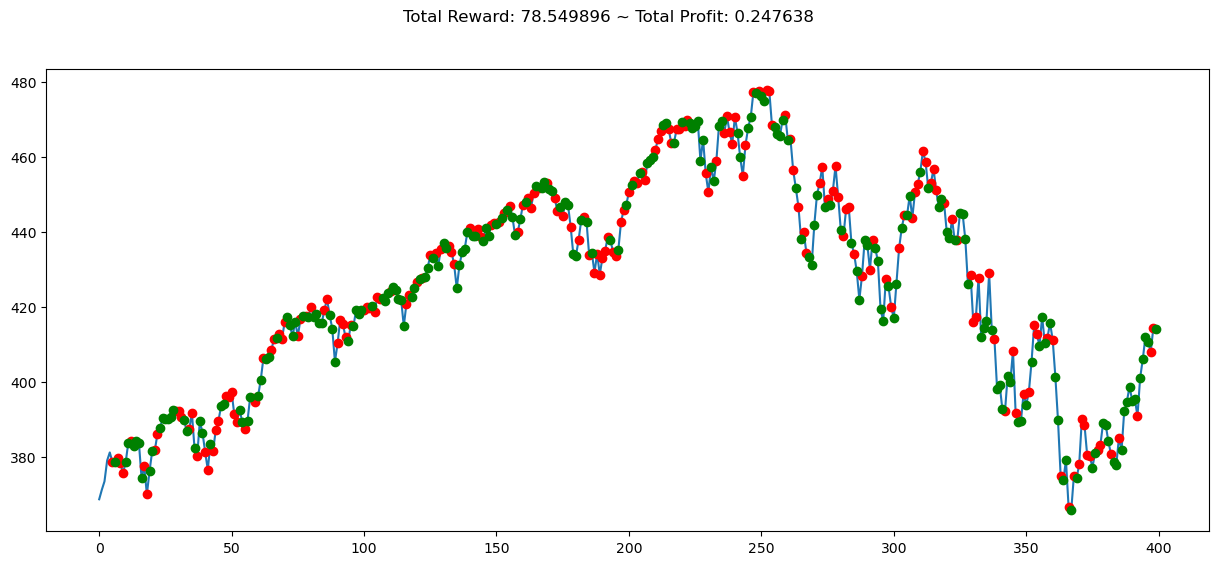

In [21]:
state = env.reset()

while True:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    
    if done:
        print(info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()


The green dots represent buying while the red dots represent selling stocks.

## Train an `A2C` algorithm from `stable-baselines`

In [22]:
env = gym.make('stocks-v0', df=df, frame_bound=(5, 400), window_size=5)
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 27.4     |
| time/                 |          |
|    fps                | 3008     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.663   |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.664   |
|    value_loss         | 1.85     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 27.5     |
| time/                 |          |
|    fps                | 3430     |
|    iterations         | 200      |
|    time_elapsed 

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 394       |
|    ep_rew_mean        | 14        |
| time/                 |           |
|    fps                | 3928      |
|    iterations         | 1400      |
|    time_elapsed       | 1         |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -0.676    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1399      |
|    policy_loss        | 4.39      |
|    value_loss         | 63.4      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 14.6     |
| time/                 |          |
|    fps                | 3937     |
|    iterations         | 1500     |
|    time_elapsed       | 1        |
|    total_timesteps    | 7500     |
| train/             

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 394       |
|    ep_rew_mean        | 21.6      |
| time/                 |           |
|    fps                | 3988      |
|    iterations         | 2700      |
|    time_elapsed       | 3         |
|    total_timesteps    | 13500     |
| train/                |           |
|    entropy_loss       | -0.689    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 2699      |
|    policy_loss        | 1.81      |
|    value_loss         | 10.6      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 20.8     |
| time/                 |          |
|    fps                | 3991     |
|    iterations         | 2800     |
|    time_elapsed       | 3        |
|    total_timesteps    | 14000    |
| train/             

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 19.8     |
| time/                 |          |
|    fps                | 4006     |
|    iterations         | 4000     |
|    time_elapsed       | 4        |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -0.687   |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | 2.19     |
|    value_loss         | 24.8     |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 394       |
|    ep_rew_mean        | 18.4      |
| time/                 |           |
|    fps                | 4006      |
|    iterations         | 4100      |
|    time_elapsed       | 5         |
|    total_timesteps    | 20500     |
| train/                |    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 19.9     |
| time/                 |          |
|    fps                | 4002     |
|    iterations         | 5300     |
|    time_elapsed       | 6        |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 5299     |
|    policy_loss        | 3.08     |
|    value_loss         | 17.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 19.2     |
| time/                 |          |
|    fps                | 4003     |
|    iterations         | 5400     |
|    time_elapsed       | 6        |
|    total_timesteps    | 27000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 17.9     |
| time/                 |          |
|    fps                | 4008     |
|    iterations         | 6600     |
|    time_elapsed       | 8        |
|    total_timesteps    | 33000    |
| train/                |          |
|    entropy_loss       | -0.681   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 6599     |
|    policy_loss        | -7.49    |
|    value_loss         | 149      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 17.8     |
| time/                 |          |
|    fps                | 4008     |
|    iterations         | 6700     |
|    time_elapsed       | 8        |
|    total_timesteps    | 33500    |
| train/                |          |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 394       |
|    ep_rew_mean        | 17.6      |
| time/                 |           |
|    fps                | 4010      |
|    iterations         | 8000      |
|    time_elapsed       | 9         |
|    total_timesteps    | 40000     |
| train/                |           |
|    entropy_loss       | -0.693    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 7999      |
|    policy_loss        | -0.0336   |
|    value_loss         | 0.00304   |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 17.1     |
| time/                 |          |
|    fps                | 4010     |
|    iterations         | 8100     |
|    time_elapsed       | 10       |
|    total_timesteps    | 40500    |
| train/             

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 394       |
|    ep_rew_mean        | 16.9      |
| time/                 |           |
|    fps                | 4011      |
|    iterations         | 9300      |
|    time_elapsed       | 11        |
|    total_timesteps    | 46500     |
| train/                |           |
|    entropy_loss       | -0.683    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 9299      |
|    policy_loss        | -0.77     |
|    value_loss         | 1.4       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 17.8     |
| time/                 |          |
|    fps                | 4011     |
|    iterations         | 9400     |
|    time_elapsed       | 11       |
|    total_timesteps    | 47000    |
| train/             

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 15.5     |
| time/                 |          |
|    fps                | 4010     |
|    iterations         | 10600    |
|    time_elapsed       | 13       |
|    total_timesteps    | 53000    |
| train/                |          |
|    entropy_loss       | -0.672   |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 10599    |
|    policy_loss        | 1.26     |
|    value_loss         | 6.13     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 15.9     |
| time/                 |          |
|    fps                | 4010     |
|    iterations         | 10700    |
|    time_elapsed       | 13       |
|    total_timesteps    | 53500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 15.9     |
| time/                 |          |
|    fps                | 4003     |
|    iterations         | 11900    |
|    time_elapsed       | 14       |
|    total_timesteps    | 59500    |
| train/                |          |
|    entropy_loss       | -0.676   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 11899    |
|    policy_loss        | 2.7      |
|    value_loss         | 18.1     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 16.8     |
| time/                 |          |
|    fps                | 4003     |
|    iterations         | 12000    |
|    time_elapsed       | 14       |
|    total_timesteps    | 60000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 15.3     |
| time/                 |          |
|    fps                | 4001     |
|    iterations         | 13200    |
|    time_elapsed       | 16       |
|    total_timesteps    | 66000    |
| train/                |          |
|    entropy_loss       | -0.684   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 13199    |
|    policy_loss        | 0.688    |
|    value_loss         | 1.23     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 15.5     |
| time/                 |          |
|    fps                | 4001     |
|    iterations         | 13300    |
|    time_elapsed       | 16       |
|    total_timesteps    | 66500    |
| train/                |          |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 394       |
|    ep_rew_mean        | 16.4      |
| time/                 |           |
|    fps                | 3999      |
|    iterations         | 14500     |
|    time_elapsed       | 18        |
|    total_timesteps    | 72500     |
| train/                |           |
|    entropy_loss       | -0.683    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 14499     |
|    policy_loss        | 8.84      |
|    value_loss         | 231       |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 394       |
|    ep_rew_mean        | 16.2      |
| time/                 |           |
|    fps                | 3999      |
|    iterations         | 14600     |
|    time_elapsed       | 18        |
|    total_timesteps    | 73000     |
| train/    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 13.4     |
| time/                 |          |
|    fps                | 3998     |
|    iterations         | 15800    |
|    time_elapsed       | 19       |
|    total_timesteps    | 79000    |
| train/                |          |
|    entropy_loss       | -0.68    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 15799    |
|    policy_loss        | -0.0289  |
|    value_loss         | 0.00346  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 13.3     |
| time/                 |          |
|    fps                | 3998     |
|    iterations         | 15900    |
|    time_elapsed       | 19       |
|    total_timesteps    | 79500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 14       |
| time/                 |          |
|    fps                | 3992     |
|    iterations         | 17200    |
|    time_elapsed       | 21       |
|    total_timesteps    | 86000    |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 17199    |
|    policy_loss        | -0.748   |
|    value_loss         | 1.43     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 12.9     |
| time/                 |          |
|    fps                | 3992     |
|    iterations         | 17300    |
|    time_elapsed       | 21       |
|    total_timesteps    | 86500    |
| train/                |          |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 394       |
|    ep_rew_mean        | 12        |
| time/                 |           |
|    fps                | 3991      |
|    iterations         | 18500     |
|    time_elapsed       | 23        |
|    total_timesteps    | 92500     |
| train/                |           |
|    entropy_loss       | -0.689    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 18499     |
|    policy_loss        | 7.34      |
|    value_loss         | 202       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 12.4     |
| time/                 |          |
|    fps                | 3991     |
|    iterations         | 18600    |
|    time_elapsed       | 23       |
|    total_timesteps    | 93000    |
| train/             

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 9.44     |
| time/                 |          |
|    fps                | 3990     |
|    iterations         | 19800    |
|    time_elapsed       | 24       |
|    total_timesteps    | 99000    |
| train/                |          |
|    entropy_loss       | -0.682   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 19799    |
|    policy_loss        | -0.0258  |
|    value_loss         | 0.00246  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 394       |
|    ep_rew_mean        | 9.15      |
| time/                 |           |
|    fps                | 3990      |
|    iterations         | 19900     |
|    time_elapsed       | 24        |
|    total_timesteps    | 99500     |
| train/                |    

## Exploit the trained agent in test simulations

In [23]:
env = gym.make('stocks-v0', df=df, frame_bound=(400, 502), window_size=5)
obs = env.reset()

while True:
    obs = obs[np.newaxis, ...]
    action, states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    
    if done:
        print(info)
        break

{'total_reward': 13.859954833984375, 'total_profit': 0.7198078647871917, 'position': 0}


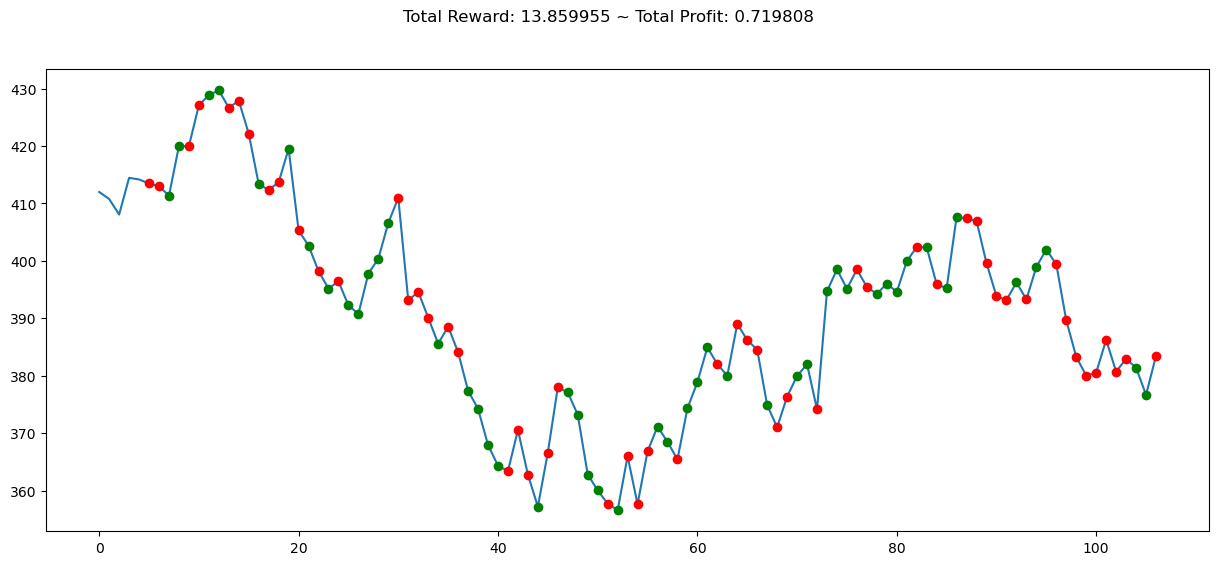

In [24]:
plt.figure(figsize=(15, 6))
plt.cla()
env.render_all()
plt.show()

Again, the green dots represent buying while the red dots represent selling stocks. If the agent is capable of making intelligent trading decisions, it will tend to buy (green dots) when the price is relatively low, and to sell (red dots) when the price is relatively high. 

As you can see, the agent needs fine tuning to perform well. So to close the lab, let us fine tune the agent by engineering features ("financial indicators") and adding these additional indicators to the definition of the RL state, so the agent has additional information every day to make trading decisions.

## Engineer features (financial indicators) for the agent to make smarter decisions

In [25]:
data = pdr.get_data_yahoo('SPY', start='2021-01-01', end='2023-01-01')
# Engineer financial indicators using the method imported above from the "TA" library
df2 = add_all_ta_features(data, open='Open', high='High', low='Low', close='Close', volume='Volume', fillna=True)

[*********************100%***********************]  1 of 1 completed


/Users/jcur/opt/anaconda3/envs/py39-flappybird/lib/python3.9/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._trs[0] = diff_directional_movement.dropna()[
/Users/jcur/opt/anaconda3/envs/py39-flappybird/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/jcur/opt/anaconda3/envs/py39-flappybird/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [26]:
pd.set_option('display.max_columns', None)

In [27]:
df2.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,375.309998,375.450012,364.820007,368.790009,358.128693,110210800,-2.788967e+07,110210800,-0.253057,0.000000e+00,0.000000,0.000000,-1.298429e+07,369.686676,50.0,1000.000000,368.790009,368.790009,368.790009,0.000000,0.000000,0.0,0.0,369.686676,380.316681,359.056671,5.750819,0.457824,0.0,0.0,364.820007,375.450012,370.135010,2.882400,0.373471,0.0,0.0,0.000000,0.000000,0.000000,368.790009,368.790009,368.790009,368.790009,0.000000,0.000000,0.000000,-11.511164,1.000000,48.833789,-116.932486,-116.932486,0.000000,370.135010,370.135010,370.135010,370.135010,0.0,0.0,0.0,0.0,0.000000,415.669847,414.121871,4.0,4.0,0.0,369.119995,375.450012,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.000000,37.347125,37.347125,-62.652875,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,368.790009,-11.693249,0.000000,0.000000
2021-01-05,368.100006,372.500000,368.049988,371.329987,360.595245,66426200,3.606493e+06,176637000,0.020418,1.687211e+08,0.937779,0.937779,-1.242972e+07,370.040166,100.0,1006.887329,370.059998,372.599976,367.520020,1.372738,0.750000,0.0,0.0,370.156667,377.696676,362.616659,4.073955,0.577806,0.0,0.0,364.820007,375.450012,370.135010,2.872508,0.612415,0.0,0.0,0.202619,0.040524,0.162095,370.059998,370.059998,369.180774,368.978155,0.134139,0.129249,0.004890,0.001345,1.904766,47.563800,-113.891498,-115.411992,1.520494,370.135010,370.135010,370.135010,370.135010,0.0,0.0,0.0,0.0,66.666667,415.669847,414.121871,8.0,4.0,4.0,369.119995,375.450012,0.0,0.0,100.0,0.0,0.0,0.0,100.0,21.750630,61.241545,49.294335,-38.758455,0.0,0.0,0.054914,0.010983,0.043931,-3.265280,-0.653056,-2.612224,369.172233,0.688733,0.686372,0.688733
2021-01-06,369.709991,376.980011,369.119995,373.549988,362.751099,107997700,1.734621e+07,284634700,0.060942,1.788688e+08,20.196371,10.567075,1.103165e+06,371.245411,100.0,1006.887329,371.223328,375.112760,367.333895,2.095468,0.799100,0.0,0.0,371.176666,378.823344,363.529989,4.120236,0.655186,0.0,0.0,364.820007,376.980011,370.900009,3.275657,0.717926,0.0,0.0,0.536152,0.139649,0.396502,371.223328,371.223328,369.852961,369.316809,0.255092,0.165557,0.089535,0.004707,2.802384,46.400470,-111.105905,-113.976630,2.870725,370.900009,370.900009,370.900009,370.900009,0.0,0.0,0.0,0.0,100.000000,415.669847,414.121871,12.0,4.0,8.0,369.119995,375.450012,0.0,1.0,100.0,0.0,0.0,0.0,100.0,33.609330,71.792581,56.793750,-28.207419,0.0,0.0,0.145174,0.037821,0.107353,-2.684186,-1.059282,-1.624904,369.548749,0.597851,0.596071,1.290702
2021-01-07,376.100006,379.899994,375.910004,379.100006,368.140625,68766800,5.853771e+07,353401500,0.1

In [28]:
def my_processed_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Volume', 'momentum_rsi', 'volume_obv', 'trend_macd_diff']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(StocksEnv):
    _process_data = my_processed_data
    

In [29]:
env2 = MyCustomEnv(df=df2, window_size= 5, frame_bound=(5, 400))

## Re-train the `A2C` algorithm from `stable-baselines` with the new engineered features

In [30]:
model = A2C('MlpPolicy', env2, verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 20.3     |
| time/                 |          |
|    fps                | 3121     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.634   |
|    explained_variance | -9.4     |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.41     |
|    value_loss         | 3.01     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 7.41     |
| time/                 |          |
|    fps                | 3492     |
|    iterations         | 200      |
|    time_elapsed 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 48       |
| time/                 |          |
|    fps                | 3876     |
|    iterations         | 1400     |
|    time_elapsed       | 1        |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -0.324   |
|    explained_variance | -1.4e+03 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | 0.0242   |
|    value_loss         | 0.0387   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 49.9     |
| time/                 |          |
|    fps                | 3883     |
|    iterations         | 1500     |
|    time_elapsed       | 1        |
|    total_timesteps    | 7500     |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 66.4     |
| time/                 |          |
|    fps                | 3930     |
|    iterations         | 2700     |
|    time_elapsed       | 3        |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -0.259   |
|    explained_variance | -7.95    |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | -0.28    |
|    value_loss         | 9.16     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 67.4     |
| time/                 |          |
|    fps                | 3932     |
|    iterations         | 2800     |
|    time_elapsed       | 3        |
|    total_timesteps    | 14000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 76.7     |
| time/                 |          |
|    fps                | 3948     |
|    iterations         | 4000     |
|    time_elapsed       | 5        |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -0.187   |
|    explained_variance | 0.00555  |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | -0.394   |
|    value_loss         | 48.3     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 77.2     |
| time/                 |          |
|    fps                | 3949     |
|    iterations         | 4100     |
|    time_elapsed       | 5        |
|    total_timesteps    | 20500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 86.7     |
| time/                 |          |
|    fps                | 3961     |
|    iterations         | 5300     |
|    time_elapsed       | 6        |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -0.553   |
|    explained_variance | -0.0985  |
|    learning_rate      | 0.0007   |
|    n_updates          | 5299     |
|    policy_loss        | -0.195   |
|    value_loss         | 0.475    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 87.1     |
| time/                 |          |
|    fps                | 3962     |
|    iterations         | 5400     |
|    time_elapsed       | 6        |
|    total_timesteps    | 27000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 89       |
| time/                 |          |
|    fps                | 3968     |
|    iterations         | 6700     |
|    time_elapsed       | 8        |
|    total_timesteps    | 33500    |
| train/                |          |
|    entropy_loss       | -0.221   |
|    explained_variance | 0.5      |
|    learning_rate      | 0.0007   |
|    n_updates          | 6699     |
|    policy_loss        | -0.0443  |
|    value_loss         | 0.175    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 89       |
| time/                 |          |
|    fps                | 3969     |
|    iterations         | 6800     |
|    time_elapsed       | 8        |
|    total_timesteps    | 34000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 92.9     |
| time/                 |          |
|    fps                | 3972     |
|    iterations         | 8100     |
|    time_elapsed       | 10       |
|    total_timesteps    | 40500    |
| train/                |          |
|    entropy_loss       | -0.0909  |
|    explained_variance | 0.0331   |
|    learning_rate      | 0.0007   |
|    n_updates          | 8099     |
|    policy_loss        | 0.0639   |
|    value_loss         | 50.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 93.8     |
| time/                 |          |
|    fps                | 3972     |
|    iterations         | 8200     |
|    time_elapsed       | 10       |
|    total_timesteps    | 41000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 103      |
| time/                 |          |
|    fps                | 3970     |
|    iterations         | 9500     |
|    time_elapsed       | 11       |
|    total_timesteps    | 47500    |
| train/                |          |
|    entropy_loss       | -0.298   |
|    explained_variance | 0.131    |
|    learning_rate      | 0.0007   |
|    n_updates          | 9499     |
|    policy_loss        | -0.229   |
|    value_loss         | 3.52     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 103      |
| time/                 |          |
|    fps                | 3970     |
|    iterations         | 9600     |
|    time_elapsed       | 12       |
|    total_timesteps    | 48000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 107      |
| time/                 |          |
|    fps                | 3969     |
|    iterations         | 10900    |
|    time_elapsed       | 13       |
|    total_timesteps    | 54500    |
| train/                |          |
|    entropy_loss       | -0.31    |
|    explained_variance | -3.23    |
|    learning_rate      | 0.0007   |
|    n_updates          | 10899    |
|    policy_loss        | -0.437   |
|    value_loss         | 18.3     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 107      |
| time/                 |          |
|    fps                | 3969     |
|    iterations         | 11000    |
|    time_elapsed       | 13       |
|    total_timesteps    | 55000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 109      |
| time/                 |          |
|    fps                | 3968     |
|    iterations         | 12300    |
|    time_elapsed       | 15       |
|    total_timesteps    | 61500    |
| train/                |          |
|    entropy_loss       | -0.363   |
|    explained_variance | 0.155    |
|    learning_rate      | 0.0007   |
|    n_updates          | 12299    |
|    policy_loss        | -2.36    |
|    value_loss         | 15.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 109      |
| time/                 |          |
|    fps                | 3968     |
|    iterations         | 12400    |
|    time_elapsed       | 15       |
|    total_timesteps    | 62000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 110      |
| time/                 |          |
|    fps                | 3967     |
|    iterations         | 13700    |
|    time_elapsed       | 17       |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -0.193   |
|    explained_variance | -0.348   |
|    learning_rate      | 0.0007   |
|    n_updates          | 13699    |
|    policy_loss        | -2.7     |
|    value_loss         | 924      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 110      |
| time/                 |          |
|    fps                | 3967     |
|    iterations         | 13800    |
|    time_elapsed       | 17       |
|    total_timesteps    | 69000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 112      |
| time/                 |          |
|    fps                | 3967     |
|    iterations         | 15100    |
|    time_elapsed       | 19       |
|    total_timesteps    | 75500    |
| train/                |          |
|    entropy_loss       | -0.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 15099    |
|    policy_loss        | 3.55     |
|    value_loss         | 23.1     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 111      |
| time/                 |          |
|    fps                | 3967     |
|    iterations         | 15200    |
|    time_elapsed       | 19       |
|    total_timesteps    | 76000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 111      |
| time/                 |          |
|    fps                | 3966     |
|    iterations         | 16400    |
|    time_elapsed       | 20       |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -0.0253  |
|    explained_variance | -0.233   |
|    learning_rate      | 0.0007   |
|    n_updates          | 16399    |
|    policy_loss        | 0.00611  |
|    value_loss         | 1.97     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 111      |
| time/                 |          |
|    fps                | 3966     |
|    iterations         | 16500    |
|    time_elapsed       | 20       |
|    total_timesteps    | 82500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 110      |
| time/                 |          |
|    fps                | 3965     |
|    iterations         | 17800    |
|    time_elapsed       | 22       |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -0.227   |
|    explained_variance | 0.0771   |
|    learning_rate      | 0.0007   |
|    n_updates          | 17799    |
|    policy_loss        | 1.37     |
|    value_loss         | 24.5     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 110      |
| time/                 |          |
|    fps                | 3965     |
|    iterations         | 17900    |
|    time_elapsed       | 22       |
|    total_timesteps    | 89500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 108      |
| time/                 |          |
|    fps                | 3964     |
|    iterations         | 19200    |
|    time_elapsed       | 24       |
|    total_timesteps    | 96000    |
| train/                |          |
|    entropy_loss       | -0.385   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 19199    |
|    policy_loss        | -1.48    |
|    value_loss         | 56.4     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 108      |
| time/                 |          |
|    fps                | 3964     |
|    iterations         | 19300    |
|    time_elapsed       | 24       |
|    total_timesteps    | 96500    |
| train/                |          |
|

## Exploit the trained agent in test simulations

In [31]:
env = MyCustomEnv(df=df2, window_size=5, frame_bound=(400, 502))
obs = env.reset()

while True:
    obs = obs[np.newaxis, ...]
    action, states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    
    if done:
        print(info)
        break

{'total_reward': -17.2000732421875, 'total_profit': 0.6761530130420447, 'position': 0}


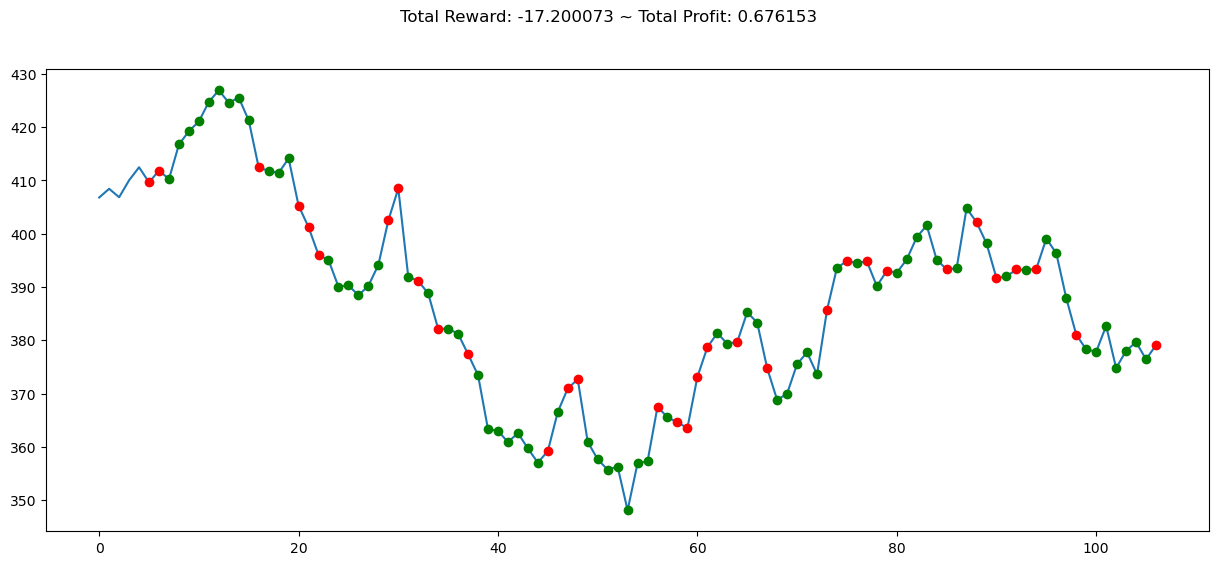

In [32]:
plt.figure(figsize=(15, 6))
plt.cla()
env.render_all()
plt.show()

Hopefully you now see more green dots (buy stocks) when the price is relatively low, and more red dots (sell stocks) when the price is relatively high!

**Exercise 1**: What other fine tuning can you try to improve the agent's trading performance?

**Exercise 2**: Implement the `CartPole` and `SpaceInvaders` agents of part 1 of this lab using the DQN algorithms from `stable-baselines`.  

**Exercise 3**: Implement the `PPO` algorithm from `stable-baselines` to learn to play at the `FlappyBird` (lab 5) and `SpaceInvaders` games.

## Thank you everyone!